In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader.data import DataReader

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier, XGBRegressor
import xgboost as xgb

import tensorflow as tf
print(tf.__version__)

import autoencoder
import model
import json
import requests
from datetime import datetime
from datetime import timedelta
sns.set()

1.15.2


In [ ]:
r = requests.get('https://api.alternative.me/fng/?limit=1500')
data = json.loads(r.text)

df_fearGreed = pd.DataFrame(data["data"], columns=["timestamp", "value"]).rename(columns={"timestamp": "DATE", "value": "Fear&Greed"})
df_fearGreed["DATE"] = pd.to_datetime(df_fearGreed["DATE"], unit="s")
df_fearGreed["Fear&Greed"] = df_fearGreed["Fear&Greed"].astype(float)
df_fearGreed = df_fearGreed.set_index("DATE")

In [4]:
start = datetime(2018, 2, 1)
end = datetime(2020, 8, 21)
Indicators = DataReader(["CBBTCUSD", "CBBCHUSD", "CBCCIND", "CBETHUSD", "sp500", "VIXCLS", "T10YIE", "DGS5", "GOLDPMGBD230NLBM", "SLVPRUSD"], 'fred', start, end)\
    .fillna(method="pad").fillna(method="backfill").join(df_fearGreed).fillna(50)

In [5]:
Indicators.to_csv('dataset/Indicators.csv', index=True, header=True)

In [4]:
Indicators = pd.read_csv('dataset/Indicators.csv', index_col="DATE")

In [6]:
Indicators

,CBBTCUSD,CBBCHUSD,CBCCIND,CBETHUSD,sp500,VIXCLS,T10YIE,DGS5,GOLDPMGBD230NLBM,SLVPRUSD,Fear&Greed
DATE,,,,,,,,,,,
2018-02-01,9014.23,1254.86,4512.850019,1017.48,2821.98,13.47,2.11,2.56,1078.58,17.190,30.0
2018-02-02,8787.52,1181.00,4455.297470,911.99,2762.13,17.31,2.14,2.58,1071.18,17.135,15.0
2018-02-03,9240.00,1269.71,4655.899898,969.40,2762.13,17.31,2.14,2.58,1071.18,17.135,40.0
2018-02-04,8167.91,1156.16,4168.798254,826.00,2762.13,17.31,2.14,2.58,1071.18,17.135,24.0
2018-02-05,6905.19,880.00,3520.919532,693.54,2648.94,37.32,2.10,2.50,1075.01,16.875,11.0
...,...,...,...,...,...,...,...,...,...,...,...
2020-08-12,11563.16,284.25,3180.272971,386.66,3380.35,22.28,1.67,0.30,1640.57,25.810,75.0
2020-08-13,11824.99,297.06,3180.272971,426.65,3373.43,22.13,1.67,0.32,1640.17,26.250,75.0
2020-08-14,11785.29,294.26,3180.272971,439.26,3372.85,22.05,1.65,0.29,1643.31,26.705,78.0


In [7]:
Indicators_pct = Indicators.pct_change()

date_ori = pd.to_datetime(Indicators_pct.index).tolist()
minmax = MinMaxScaler().fit(Indicators.iloc[:, 0].values.reshape((-1,1)))
scaler = MinMaxScaler().fit(Indicators)
Indicators_sca = Indicators.copy()
Indicators_sca[:] = scaler.transform(Indicators)

Indicators_full = pd.concat([Indicators_pct, Indicators_sca], axis=1)

In [8]:
df_log = Indicators_sca
Indicators_sca

,CBBTCUSD,CBBCHUSD,CBCCIND,CBETHUSD,sp500,VIXCLS,T10YIE,DGS5,GOLDPMGBD230NLBM,SLVPRUSD,Fear&Greed
DATE,,,,,,,,,,,
2018-02-01,0.599950,0.704644,0.780713,1.000000,0.508884,0.036470,0.958333,0.817241,0.088547,0.317611,0.277778
2018-02-02,0.576625,0.660487,0.767465,0.887114,0.456783,0.089922,0.976190,0.824138,0.078403,0.314242,0.111111
2018-02-03,0.623179,0.713522,0.813643,0.948549,0.456783,0.089922,0.976190,0.824138,0.078403,0.314242,0.388889
2018-02-04,0.512876,0.645636,0.701513,0.795095,0.456783,0.089922,0.976190,0.824138,0.078403,0.314242,0.211111
2018-02-05,0.382960,0.480534,0.552373,0.653347,0.358250,0.368458,0.952381,0.796552,0.083653,0.298315,0.066667
...,...,...,...,...,...,...,...,...,...,...,...
2020-08-12,0.862199,0.124365,0.473957,0.324951,0.994951,0.159104,0.696429,0.037931,0.858988,0.845636,0.777778
2020-08-13,0.889138,0.132023,0.473957,0.367745,0.988927,0.157016,0.696429,0.044828,0.858439,0.872588,0.777778
2020-08-14,0.885053,0.130349,0.473957,0.381239,0.988422,0.155902,0.684524,0.034483,0.862744,0.900459,0.811111


In [9]:
thought_vector = autoencoder.reducedimension(df_log.values, 6, 0.001, 128, 150)




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


epoch: 10 loss: 0.2897228 time: 0.0015101432800292969
epoch: 20 loss: 0.28939402 time: 0.0013852119445800781
epoch: 30 loss: 0.2888413 time: 0.0013878345489501953
epoch: 40 loss: 0.28791612 time: 0.0017719268798828125
epoch: 50 loss: 0.28637725 time: 0.001631021499633789
epoch: 60 loss: 0.28383225 time: 0.002373933792114258
epoch: 70 loss: 0.27960712 time: 0.001857757568359375
epoch: 80 loss: 0.27231136 time: 0.0014629364013671875
epoch: 90 loss: 0.25837368 time: 0.0017819404602050781
epoch: 100 loss: 0.23019749 time: 0.0016698837280273438
epoch: 110 loss: 0.19311385 time: 0.0013632774353027344
epoch: 120 loss: 0.17364646 time: 0.0015959739685058594
epoch: 130 loss: 0.1643086 time: 0.0021071434020996094
epoch: 140 loss: 0.15965474 time: 0.0020568370819091797
epoch: 150 los

In [25]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 500
dropout_rate = 0.5

In [26]:
tf.reset_default_graph()
modelnn = model.Model(0.01, num_layers, thought_vector.shape[1], size_layer, 1, dropout_rate)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
for i in range(epoch):
    init_value = np.zeros((1, num_layers * 2 * size_layer))
    total_loss = 0
    for k in range(0, (thought_vector.shape[0] // timestamp) * timestamp, timestamp):
        batch_x = np.expand_dims(thought_vector[k: k + timestamp, :], axis = 0)
        batch_y = df_log.values[k + 1: k + timestamp + 1, 3].reshape([-1, 1])
        last_state, _, loss = sess.run([modelnn.last_state, 
                                        modelnn.optimizer, 
                                        modelnn.cost], feed_dict={modelnn.X: batch_x, 
                                                                  modelnn.Y: batch_y, 
                                                                  modelnn.hidden_layer: init_value})
        init_value = last_state
        total_loss += loss
    total_loss /= (thought_vector.shape[0] // timestamp)
    if (i + 1) % 100 == 0:
        print('epoch:', i + 1, 'avg loss:', total_loss)

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

epoch: 100 avg loss: 0.03408520187478306
epoch: 200 avg loss: 0.02164828455182555
e

In [27]:
output_predict = np.zeros(((thought_vector.shape[0] // timestamp) * timestamp, 1))
init_value = np.zeros((1, num_layers * 2 * size_layer))
for k in range(0, (thought_vector.shape[0] // timestamp) * timestamp, timestamp):
    out_logits, last_state = sess.run([modelnn.logits, modelnn.last_state], feed_dict = {modelnn.X:np.expand_dims(thought_vector[k: k + timestamp, :], axis = 0),
                                     modelnn.hidden_layer: init_value})
    init_value = last_state
    output_predict[k: k + timestamp, :] = out_logits

In [28]:
print('Mean Square Error:', np.mean(np.square(output_predict[:, 0] - df_log.iloc[1: (thought_vector.shape[0] // timestamp) * timestamp + 1, 0].values)))

Mean Square Error: 0.125419196376562


In [29]:
import statsmodels.api as sm
from itertools import product
from scipy import stats
    
Qs = range(0, 1)
qs = range(0, 2)
Ps = range(0, 2)
ps = range(0, 2)
D=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
best_aic = float("inf")
for param in parameters_list:
#     try:
    arima=sm.tsa.statespace.SARIMAX(df_log.iloc[:,0].values, order=(param[0], D, param[1]), seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
#     except:
#         continue
    aic = arima.aic
    if aic < best_aic and aic:
        best_arima = arima
        best_aic = aic
        
best_aic

/Users/jojo/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


-4652.390391582033

In [30]:
def reverse_close(array):
    return minmax.inverse_transform(array.reshape((-1,1))).reshape((-1))

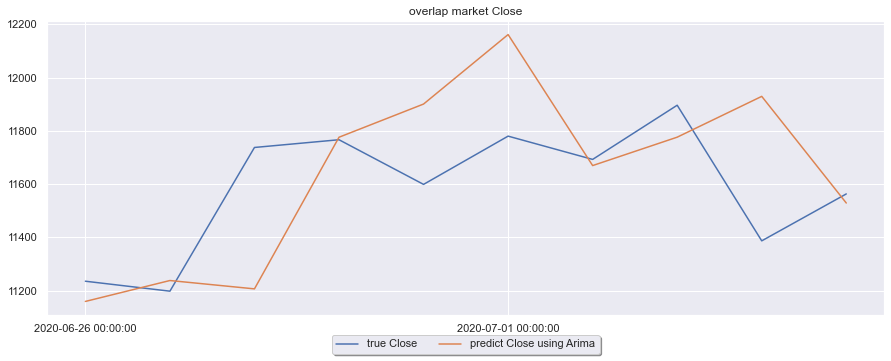

In [31]:
last =10

pred_arima = best_arima.predict()
x_range = np.arange(df_log.shape[0])[-last:]
fig = plt.figure(figsize = (15,6))
ax = plt.subplot(111)
ax.plot(x_range, reverse_close(df_log.iloc[:,0].values)[-last:], label = 'true Close')
ax.plot(x_range, reverse_close(pred_arima)[-last:], label = 'predict Close using Arima')
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
ax.legend(loc = 'upper center', bbox_to_anchor= (0.5, -0.05), fancybox = True, shadow = True, ncol = 5)
plt.xticks(x_range[::5], date_ori[::5][-last:])
plt.title('overlap market Close')
plt.show()

In [32]:
boundary = (thought_vector.shape[0] // timestamp) * timestamp
stack_predict = np.vstack([pred_arima[:boundary], output_predict.reshape((-1))]).T

In [33]:
where_below_0 = np.where(stack_predict < 0)
where_higher_1 = np.where(stack_predict > 1)
stack_predict[where_below_0[0], where_below_0[1]] = 0
stack_predict[where_higher_1[0], where_higher_1[1]] = 1

In [34]:
corr_df = pd.DataFrame(np.hstack([stack_predict, df_log.values[:boundary, 0].reshape((-1,1))]))

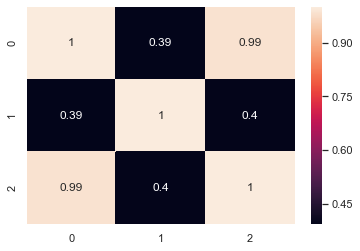

In [35]:
sns.heatmap(corr_df.corr(), annot= True)
plt.show()

In [ ]:
params_xgd = {
    'max_depth': 7,
    'objective': 'reg:logistic',
    'learning_rate': 0.05,
    'n_estimators': 10000
    }
train_Y = df_log.values[:boundary, 0]
clf = xgb.XGBRegressor(**params_xgd)
clf.fit(stack_predict,train_Y, eval_set=[(stack_predict,train_Y)], 
        eval_metric='rmse', early_stopping_rounds=20, verbose=False)